In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, recall_score, f1_score, auc
from sklearn.metrics import auc as calc_auc, precision_recall_curve, average_precision_score, precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import random
import glob
import h5py
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
from omegaconf import OmegaConf
from omegaconf import DictConfig
from sklearn.preprocessing import label_binarize

import warnings
import copy
import seaborn as sns

In [2]:
conf_preproc = OmegaConf.load("../../conf/preproc.yaml")
conf_preproc = conf_preproc["classic_mil_on_embeddings_bag"]["jmcs_224_224_patches"]

In [3]:
if torch.cuda.is_available():
    DEVICE = 'cuda:0' 
else:
    DEVICE = 'cpu'
print("Device:", DEVICE)

Device: cuda:0


## VALIDATION FOLDS

In [4]:
def give_back_hard_label_predictions_with_threshold_tuning(prob_pred_array, threshold_values):
    
    # Calculate the predicted labels for this set
    preds_threshold_tuned = np.copy(prob_pred_array) # final_pred_ensemble_local_test_macenko)

    filt_3 = (preds_threshold_tuned[:,2] > threshold_values[-1])
    preds_threshold_tuned[filt_3,:] = np.array([0,0,1]) # 1.0

    filt_2 = (preds_threshold_tuned[~filt_3,1] > threshold_values[-2])
    idxs_2 = np.arange( preds_threshold_tuned.shape[0] )[~filt_3][filt_2]
    preds_threshold_tuned[idxs_2,:] = np.array([0,1,0]) # 1.0

    
    predicted_labels = np.argmax(preds_threshold_tuned, axis=1)
    
    return predicted_labels

## LOCAL TEST SET

In [5]:
biopsy_bag_input_path = conf_preproc.uni_finetuned_biopsy_dir_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev

biopsy_df_local_test = pd.read_csv(
    "../../cv_splits_paper/cv_splits_multi_stratified_sklearn_s_a_r_mo_paper_patients_rev/final_df_with_excluded_slides_cluster_tsne_1_2_3.csv",
    dtype={"Pathological": int})
biopsy_df_local_test.sort_values('patient_ngsci_id', inplace=True)
biopsy_bag_input_files_local_test = np.array( sorted([ biopsy_bag_input_path+i+'.h5' for i in biopsy_df_local_test.patient_ngsci_id.values ]) )

y_true = biopsy_df_local_test.Pathological.values -1

biopsy_bag_input_files_local_test.shape, y_true.shape

((574,), (574,))

In [6]:
preds_ensemble_local_test = np.load('../../04_prediction/sote_paper_patients_tsne_slides_filtered_rev_tuned/preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_NG_cohort_excluded_slides_cluster_tsne_1_2_3_rev.npy')
final_pred_ensemble_local_test = np.mean(preds_ensemble_local_test, axis=0)
final_pred_ensemble_local_test.shape

(574, 3)

In [7]:
final_pred_ensemble_local_test;

In [8]:
thresholds_final = np.load('thresholds_sote_final_uni_finetuned_sote_sqrt_paper_rev.npy')
thresholds_final

array([0.387, 0.29 , 0.374], dtype=float32)

In [9]:
predicted_labels = give_back_hard_label_predictions_with_threshold_tuning(final_pred_ensemble_local_test, thresholds_final)

### metrics on local test

In [10]:
y_true.shape, predicted_labels.shape

((574,), (574,))

In [11]:
np.unique(y_true, return_counts=True), np.unique(predicted_labels, return_counts=True)

((array([0, 1, 2]), array([478,  70,  26])),
 (array([0, 1, 2]), array([161, 258, 155])))

In [12]:
y_true.shape, final_pred_ensemble_local_test.shape

((574,), (574, 3))

In [13]:
y_true_oh = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3).numpy()

roc_auc = roc_auc_score(y_true_oh, final_pred_ensemble_local_test, multi_class="ovr", average="macro")
print("ROC macro:", roc_auc)

roc_auc = roc_auc_score(y_true_oh, final_pred_ensemble_local_test, multi_class="ovr", average="weighted")
print("ROC weighted:", roc_auc)

f1 = f1_score(y_true, predicted_labels, average='macro')
print("F1 macro:", f1)

f1 = f1_score(y_true, predicted_labels, average='weighted')
print("F1 weighted:", f1)

accuracy = accuracy_score(y_true, predicted_labels)
print("Accuracy: ", accuracy)

ROC macro: 0.6717138112341449
ROC weighted: 0.6864455651110958
F1 macro: 0.271278278302976
F1 weighted: 0.43031472793627745
Accuracy:  0.34668989547038326


### metrics on local test - bootstrap

In [14]:
def generate_bootstrap_samples(y_true, y_pred, num_bootstrap_samples=1000, random_seed=42):
    if random_seed is not None:
        np.random.seed(random_seed)
    
    n = len(y_true)
    bootstrap_samples = []

    for _ in tqdm(range(num_bootstrap_samples)):
        while True:
            # Create bootstrap sample
            indices = np.random.randint(0, n, n)
            sample_y_true = y_true[indices]
            sample_y_pred = y_pred[indices]


            # Check if all labels are present for macro/weighted metrics
            if len(np.unique(sample_y_true)) == len(np.unique(y_true)):
                #print("first if true")
                # Check if valid one-vs-rest samples exist for each class
                valid_sample = all(
                    np.sum(sample_y_true == class_index) > 0 and np.sum(sample_y_true != class_index) > 0
                    for class_index in range(3)
                )
                if valid_sample:
                    #print("valid")
                    bootstrap_samples.append((sample_y_true, sample_y_pred))
                    break  # Exit the loop if all conditions are met

    return bootstrap_samples

In [15]:
bootstrap_samples = generate_bootstrap_samples(
    y_true, 
    final_pred_ensemble_local_test,
    num_bootstrap_samples=10000, 
    random_seed=42
)

100%|██████████| 10000/10000 [00:00<00:00, 12924.56it/s]


In [16]:
len(bootstrap_samples), bootstrap_samples[0][0].shape, bootstrap_samples[0][1].shape

(10000, (574,), (574, 3))

In [17]:
def bootstrap_metric_ci(bootstrap_samples, y_true, y_pred, confidence_level=0.95, **kwargs):
    n = len(bootstrap_samples)
    
    bootstrap_metrics = {
        "accuracy": [],
        "f1_macro": [],
        "f1_weighted": [],
        "roc_auc_macro": [],
        "roc_auc_weighted": [],
        "pr_auc_macro": [],
        "pr_auc_weighted": [],
        "classwise_aucs": {i: [] for i in range(3)},
        "classwise_pr_aucs": {i: [] for i in range(3)}
    }
    
    for sample_y_true, sample_y_pred in tqdm(bootstrap_samples):

        #sample_y_true_oh = F.one_hot(torch.from_numpy(sample_y_true).to(torch.int64), 4).numpy()
        
        # Calculate the macro and weighted ROC AUC
        #y_true_binarized = label_binarize(sample_y_true, classes=[0, 1, 2])
        y_true_binarized = F.one_hot(torch.from_numpy(sample_y_true).to(torch.int64), 3).numpy()
        roc_auc_macro = roc_auc_score(y_true_binarized, sample_y_pred, multi_class='ovr', average='macro')
        roc_auc_weighted = roc_auc_score(y_true_binarized, sample_y_pred, multi_class='ovr', average='weighted')
        bootstrap_metrics["roc_auc_macro"].append(roc_auc_macro)
        bootstrap_metrics["roc_auc_weighted"].append(roc_auc_weighted)

        # Calculate the macro and weighted Precision-Recall AUC
        pr_auc_macro = average_precision_score(y_true_binarized, sample_y_pred, average='macro')
        pr_auc_weighted = average_precision_score(y_true_binarized, sample_y_pred, average='weighted')
        bootstrap_metrics["pr_auc_macro"].append(pr_auc_macro)
        bootstrap_metrics["pr_auc_weighted"].append(pr_auc_weighted)

        # Convert probabilities to discrete class labels for F1-score and accuracy calculation
        ##sample_y_pred_labels = np.argmax(sample_y_pred, axis=1)
        sample_y_pred_labels = give_back_hard_label_predictions_with_threshold_tuning(sample_y_pred, thresholds_final)
        
        f1_macro = f1_score(sample_y_true, sample_y_pred_labels, average='macro')
        f1_weighted = f1_score(sample_y_true, sample_y_pred_labels, average='weighted')
        accuracy = accuracy_score(sample_y_true, sample_y_pred_labels)
        bootstrap_metrics["f1_macro"].append(f1_macro)
        bootstrap_metrics["f1_weighted"].append(f1_weighted)
        bootstrap_metrics["accuracy"].append(accuracy)
        
        # Calculate one-vs-rest AUC for each class (ROC AUC)
        for class_index in range(3):
            binarized_y_true = (sample_y_true == class_index).astype(int)
            fpr, tpr, _ = roc_curve(binarized_y_true, sample_y_pred[:, class_index])
            roc_auc = auc(fpr, tpr)
            bootstrap_metrics["classwise_aucs"][class_index].append(roc_auc)

            # Calculate one-vs-rest AUC for each class (Precision-Recall AUC)
            precision, recall, _ = precision_recall_curve(binarized_y_true, sample_y_pred[:, class_index])
            pr_auc = auc(recall, precision)
            bootstrap_metrics["classwise_pr_aucs"][class_index].append(pr_auc)

    # Compute single metric values on the full dataset
    #y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])
    y_true_binarized = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3).numpy()
    roc_auc_macro = roc_auc_score(y_true_binarized, y_pred, multi_class='ovr', average='macro')
    roc_auc_weighted = roc_auc_score(y_true_binarized, y_pred, multi_class='ovr', average='weighted')
    pr_auc_macro = average_precision_score(y_true_binarized, y_pred, average='macro')
    pr_auc_weighted = average_precision_score(y_true_binarized, y_pred, average='weighted')
    ##y_pred_labels = np.argmax(y_pred, axis=1)
    y_pred_labels = give_back_hard_label_predictions_with_threshold_tuning(y_pred, thresholds_final)
    
    
    f1_macro = f1_score(y_true, y_pred_labels, average='macro')
    f1_weighted = f1_score(y_true, y_pred_labels, average='weighted')
    accuracy = accuracy_score(y_true, y_pred_labels)

    single_metric_values = {
        "accuracy": accuracy,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "roc_auc_macro": roc_auc_macro,
        "roc_auc_weighted": roc_auc_weighted,
        "pr_auc_macro": pr_auc_macro,
        "pr_auc_weighted": pr_auc_weighted,
        "classwise_aucs": {},
        "classwise_pr_aucs": {}
    }

    for class_index in range(3):
        binarized_y_true = (y_true == class_index).astype(int)
        fpr, tpr, _ = roc_curve(binarized_y_true, y_pred[:, class_index])
        roc_auc = auc(fpr, tpr)
        single_metric_values["classwise_aucs"][class_index] = roc_auc

        precision, recall, _ = precision_recall_curve(binarized_y_true, y_pred[:, class_index])
        pr_auc = auc(recall, precision)
        single_metric_values["classwise_pr_aucs"][class_index] = pr_auc

    # Compute confidence intervals
    metric_cis = {}
    for metric_name in ["accuracy", "f1_macro", "f1_weighted", "roc_auc_macro", "roc_auc_weighted", "pr_auc_macro", "pr_auc_weighted"]:
        lower_bound = np.percentile(bootstrap_metrics[metric_name], (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(bootstrap_metrics[metric_name], (1 + confidence_level) / 2 * 100)
        metric_cis[metric_name] = (single_metric_values[metric_name], lower_bound, upper_bound)

    classwise_roc_cis = {}
    classwise_pr_cis = {}
    for class_index in range(3):
        lower_bound_roc = np.percentile(bootstrap_metrics["classwise_aucs"][class_index], (1 - confidence_level) / 2 * 100)
        upper_bound_roc = np.percentile(bootstrap_metrics["classwise_aucs"][class_index], (1 + confidence_level) / 2 * 100)
        classwise_roc_cis[f"Class {class_index + 1} AUC"] = (
            single_metric_values["classwise_aucs"][class_index], lower_bound_roc, upper_bound_roc
        )

        lower_bound_pr = np.percentile(bootstrap_metrics["classwise_pr_aucs"][class_index], (1 - confidence_level) / 2 * 100)
        upper_bound_pr = np.percentile(bootstrap_metrics["classwise_pr_aucs"][class_index], (1 + confidence_level) / 2 * 100)
        classwise_pr_cis[f"Class {class_index + 1} PR AUC"] = (
            single_metric_values["classwise_pr_aucs"][class_index], lower_bound_pr, upper_bound_pr
        )

    return metric_cis, classwise_roc_cis, classwise_pr_cis

In [18]:
metric_cis, classwise_roc_cis, classwise_pr_cis = bootstrap_metric_ci(
    bootstrap_samples, 
    y_true, 
    final_pred_ensemble_local_test
)

# Display single metric values and bootstrap results for the external test set
print("External test set (local test) - Single Metric Values and Bootstrap CIs:")
for metric_name, (value, lower, upper) in metric_cis.items():
    print(f"{metric_name:<20}: {round(value, 3)}, 95% CI = [{round(lower, 3)}, {round(upper, 3)}]")

print("\nOne-vs-Rest Class-wise AUCs and Bootstrap CIs (ROC):")
for class_name, (value, lower, upper) in classwise_roc_cis.items():
    print(f"{class_name:<20}: {round(value, 3)}, 95% CI = [{round(lower, 3)}, {round(upper, 3)}]")

print("\nOne-vs-Rest Class-wise AUCs and Bootstrap CIs (PR):")
for class_name, (value, lower, upper) in classwise_pr_cis.items():
    print(f"{class_name:<20}: {round(value, 3)}, 95% CI = [{round(lower, 3)}, {round(upper, 3)}]")

100%|██████████| 10000/10000 [02:09<00:00, 77.31it/s]

External test set (local test) - Single Metric Values and Bootstrap CIs:
accuracy            : 0.347, 95% CI = [0.308, 0.387]
f1_macro            : 0.271, 95% CI = [0.236, 0.307]
f1_weighted         : 0.43, 95% CI = [0.387, 0.473]
roc_auc_macro       : 0.672, 95% CI = [0.613, 0.728]
roc_auc_weighted    : 0.686, 95% CI = [0.631, 0.739]
pr_auc_macro        : 0.398, 95% CI = [0.377, 0.443]
pr_auc_weighted     : 0.781, 95% CI = [0.742, 0.826]

One-vs-Rest Class-wise AUCs and Bootstrap CIs (ROC):
Class 1 AUC         : 0.688, 95% CI = [0.63, 0.742]
Class 2 AUC         : 0.702, 95% CI = [0.641, 0.76]
Class 3 AUC         : 0.626, 95% CI = [0.513, 0.733]

One-vs-Rest Class-wise AUCs and Bootstrap CIs (PR):
Class 1 PR AUC      : 0.902, 95% CI = [0.869, 0.935]
Class 2 PR AUC      : 0.198, 95% CI = [0.148, 0.263]
Class 3 PR AUC      : 0.079, 95% CI = [0.04, 0.153]


### ROC curve with CI - simple interp

In [19]:
def calculate_bootstrap_roc_curve(bootstrap_samples, class_index):
    base_fpr = np.linspace(0, 1, 101)
    tprs = []
    aucs = []

    for sample_y_true, sample_y_pred in tqdm(bootstrap_samples):
        # Binarize the true labels for one-vs-rest classification
        binarized_y_true = (sample_y_true == class_index).astype(int)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(binarized_y_true, sample_y_pred[:, class_index])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        # Interpolate the TPR values to get consistent x-axis (FPR) values
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    
    tpr_lower = np.percentile(tprs, 2.5, axis=0)
    tpr_upper = np.percentile(tprs, 97.5, axis=0)

    # Calculate 95% CI for the AUC values
    auc_lower = np.percentile(aucs, 2.5)
    auc_upper = np.percentile(aucs, 97.5)
    
    return base_fpr, tpr_lower, tpr_upper, mean_tprs, auc_lower, auc_upper

In [20]:
def plot_roc_with_saved_bootstrap(bootstrap_samples, y_true, y_pred):
    if y_pred.shape[1] != 3:
        raise ValueError("The number of classes should be 3")

    if y_pred.shape[0] != y_true.shape[0]:
        raise ValueError("Mismatched shape between y_true and y_pred")

    # One-hot encode y_true if necessary
    if len(y_true.shape) == 1 or y_true.shape[1] != 3:
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 3).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

    for class_ind in range(y_pred.shape[1]):
        # Calculate the original ROC curve and AUC for the given class
        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])  
        roc_auc = auc(fpr, tpr)

        # Calculate bootstrap-based ROC curves and CIs using saved samples
        base_fpr, tpr_lower, tpr_upper, mean_tprs, auc_lower, auc_upper = calculate_bootstrap_roc_curve(bootstrap_samples, class_ind)

        axs[class_ind].plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', color='blue', lw=2)
        if len(tpr_lower) > 0 and len(tpr_upper) > 0:  # Check if CI is computed
            axs[class_ind].fill_between(base_fpr, tpr_lower, tpr_upper, color='lightblue', alpha=0.2, label=f'95% CI [{auc_lower:.3f}, {auc_upper:.3f}]')
        else:
            print("CI NOT COMPUTED")
        
        ## plot no skill line
        axs[class_ind].plot([0, 1], [0, 1], linestyle='dashed', lw=2, color='black', label="No skill classifier")        
        
        axs[class_ind].axis("square")
        axs[class_ind].set_xlim([-0.05, 1.05])
        axs[class_ind].set_ylim([-0.05, 1.05])
        
        axs[class_ind].set_xlabel('False Positive Rate', fontsize=22)
        axs[class_ind].set_ylabel('True Positive Rate', fontsize=22)

        stage_names = ["I", "II", "III"]
        axs[class_ind].set_title(f'Stage {stage_names[class_ind]}', fontsize=22, pad=20)
        axs[class_ind].legend(loc='lower right', fontsize=16)
        
        # Set ticks for both axes
        axs[class_ind].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].tick_params(axis='both', which='major', labelsize=22)
        axs[class_ind].xaxis.label.set_size(22)
        axs[class_ind].yaxis.label.set_size(22)
        
    plt.tight_layout()
    plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/roc_curve_with_ci_NG_cohort_uni_finetuned_rev.png')
    plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/roc_curve_with_ci_NG_cohort_uni_finetuned_rev.svg')
    plt.show()

100%|██████████| 10000/10000 [00:06<00:00, 1584.03it/s]


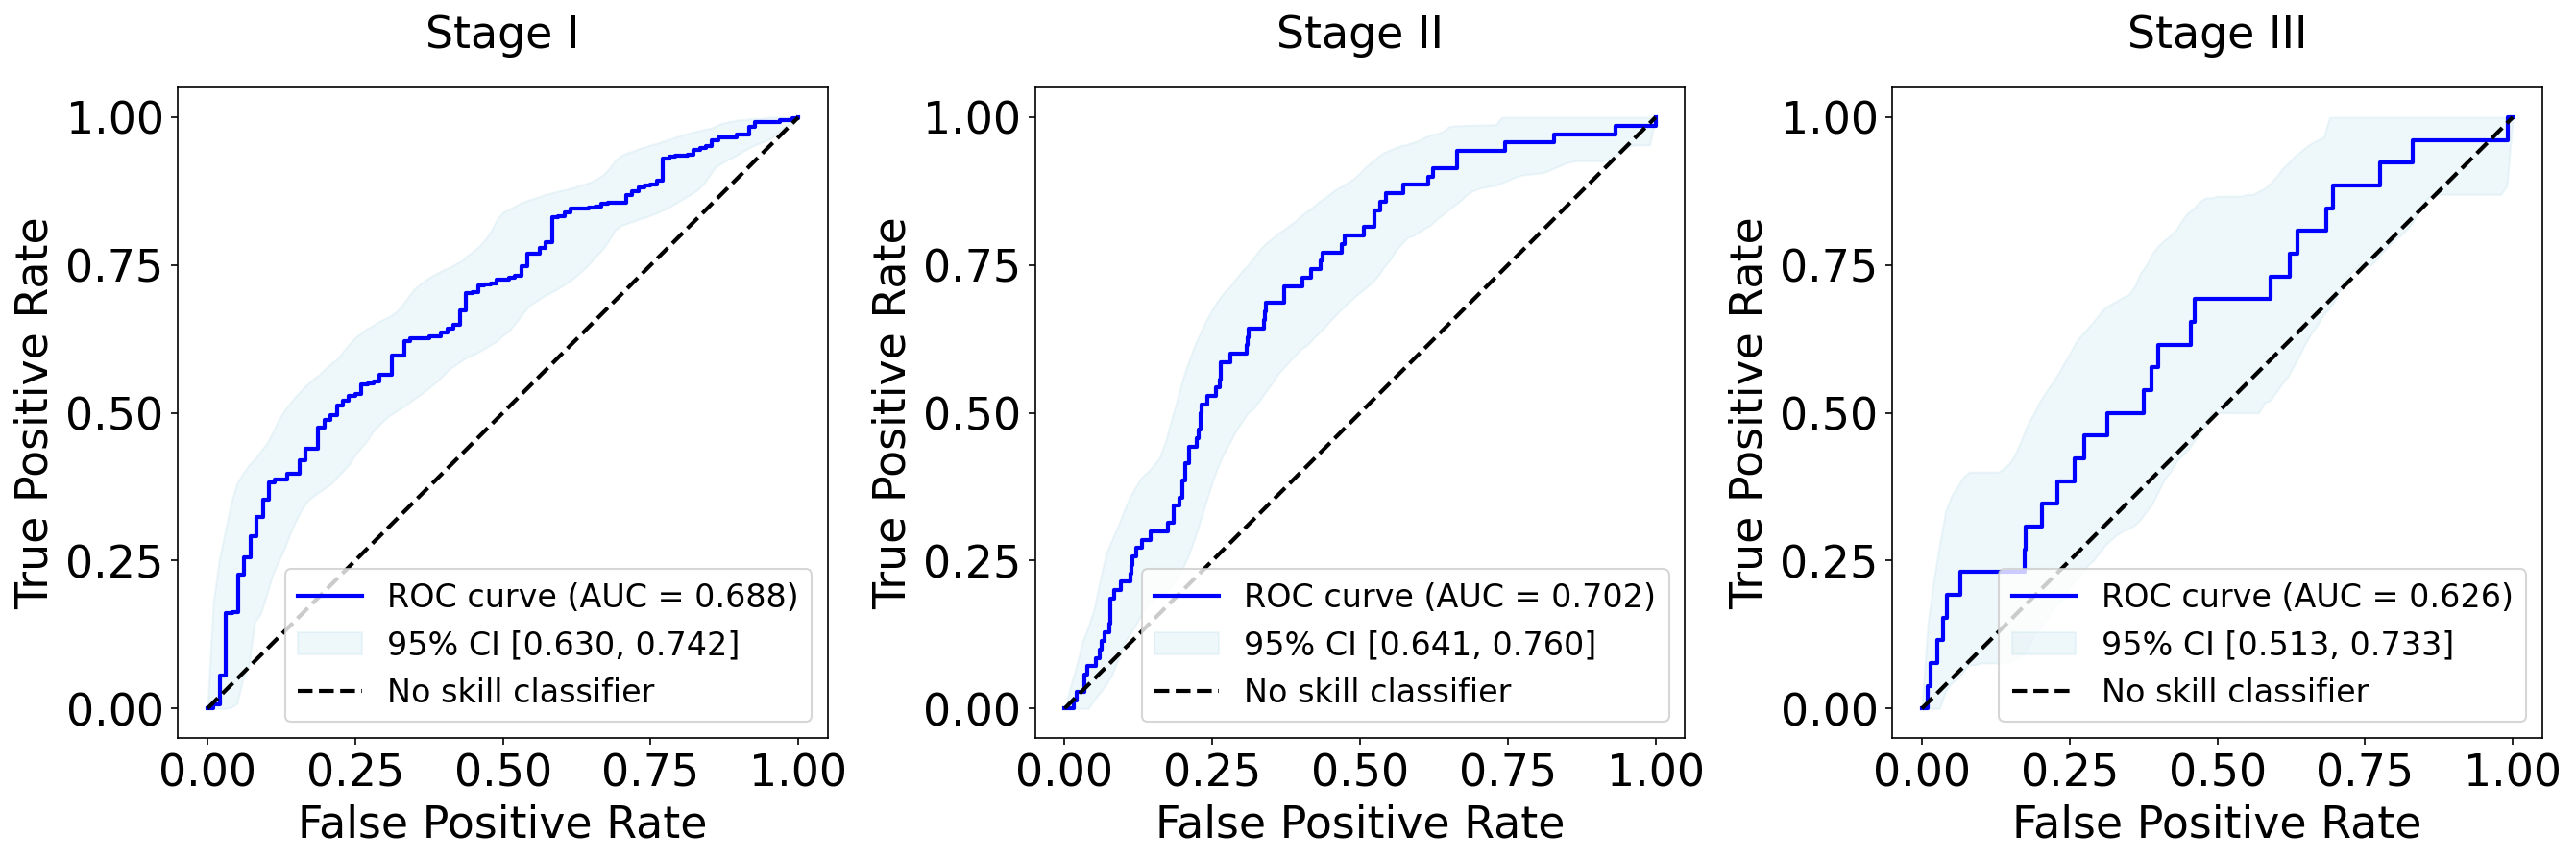

In [21]:
plot_roc_with_saved_bootstrap(bootstrap_samples, biopsy_df_local_test.Pathological.values-1, final_pred_ensemble_local_test)

### PR curve with CI - simple interp

In [22]:
def calculate_bootstrap_pr_curve_simple_interp(bootstrap_samples, class_index):
    base_recalls = np.linspace(0, 1, 101)
    precisions = []
    pr_aucs = []

    for sample_y_true, sample_y_pred in tqdm(bootstrap_samples):
        # Binarize the true labels for one-vs-rest classification
        binarized_y_true = (sample_y_true == class_index).astype(int)
        
        # Calculate precision-recall curve
        precision, recall, _ = precision_recall_curve(binarized_y_true, sample_y_pred[:, class_index])
        pr_auc = auc(recall, precision)
        pr_aucs.append(pr_auc)

        precision_interp = np.interp(base_recalls, recall[::-1], precision[::-1])
        precisions.append(precision_interp)

    precisions = np.array(precisions)
    mean_precisions = precisions.mean(axis=0)
    std_precisions = precisions.std(axis=0)
    
    precision_lower = np.percentile(precisions, 2.5, axis=0)
    precision_upper = np.percentile(precisions, 97.5, axis=0)

    # Calculate 95% CI for the PR AUC values
    pr_auc_lower = np.percentile(pr_aucs, 2.5)
    pr_auc_upper = np.percentile(pr_aucs, 97.5)
    
    return base_recalls, precision_lower, precision_upper, mean_precisions, pr_auc_lower, pr_auc_upper

In [23]:
def plot_pr_with_saved_bootstrap_simple_interp(bootstrap_samples, y_true, y_pred):
    if y_pred.shape[1] != 3:
        raise ValueError("The number of classes should be 3")

    if y_pred.shape[0] != y_true.shape[0]:
        raise ValueError("Mismatched shape between y_true and y_pred")

    # One-hot encode y_true if necessary
    if len(y_true.shape) == 1 or y_true.shape[1] != 3:
        y_true = np.eye(3)[y_true]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

    for class_ind in range(y_pred.shape[1]):
        # Calculate the original precision-recall curve and AUC for the given class
        precision, recall, _ = precision_recall_curve(y_true[:, class_ind], y_pred[:, class_ind])
        pr_auc = auc(recall, precision)

        # Calculate bootstrap-based precision-recall curves and CIs using saved samples
        base_recalls, precision_lower, precision_upper, mean_precisions, pr_auc_lower, pr_auc_upper = calculate_bootstrap_pr_curve_simple_interp(bootstrap_samples, class_ind)

        axs[class_ind].plot(recall, precision, label=f'PR curve (AP = {pr_auc:.3f})', color='green', lw=2)
        if len(precision_lower) > 0 and len(precision_upper) > 0:  # Check if CI is computed
            axs[class_ind].fill_between(base_recalls, precision_lower, precision_upper, color='lightgreen', alpha=0.2, label=f'95% CI [{pr_auc_lower:.3f}, {pr_auc_upper:.3f}]')
        else:
            print("CI NOT COMPUTED")
            
        ## plot no skill line
        axs[class_ind].hlines(
            y_true[:, class_ind].sum() / y_true[:, class_ind].shape[0], 
            0,
            1, 
            color="black", 
            label="No skill classifier",
            lw=2,
            linestyles='dashed',
            alpha=1.)

        axs[class_ind].axis("square")
        axs[class_ind].set_xlim([-0.05, 1.05])
        axs[class_ind].set_ylim([-0.05, 1.05])
        
        axs[class_ind].set_xlabel('Recall', fontsize=22)
        axs[class_ind].set_ylabel('Precision', fontsize=22)

        stage_names = ["I", "II", "III"]
        axs[class_ind].set_title(f'Stage {stage_names[class_ind]}', fontsize=22, pad=20)
        axs[class_ind].legend(fontsize=16)
        
        # Set ticks for both axes
        axs[class_ind].set_xticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].set_yticks([0.0, 0.25, 0.5, 0.75, 1.0])
        axs[class_ind].tick_params(axis='both', which='major', labelsize=22)
        axs[class_ind].xaxis.label.set_size(22)
        axs[class_ind].yaxis.label.set_size(22)
        

    plt.tight_layout()
    plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/pr_curve_with_ci_NG_cohort_uni_finetuned_rev.png')
    plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/pr_curve_with_ci_NG_cohort_uni_finetuned_rev.svg')
    plt.show()

100%|██████████| 10000/10000 [00:06<00:00, 1614.02it/s]


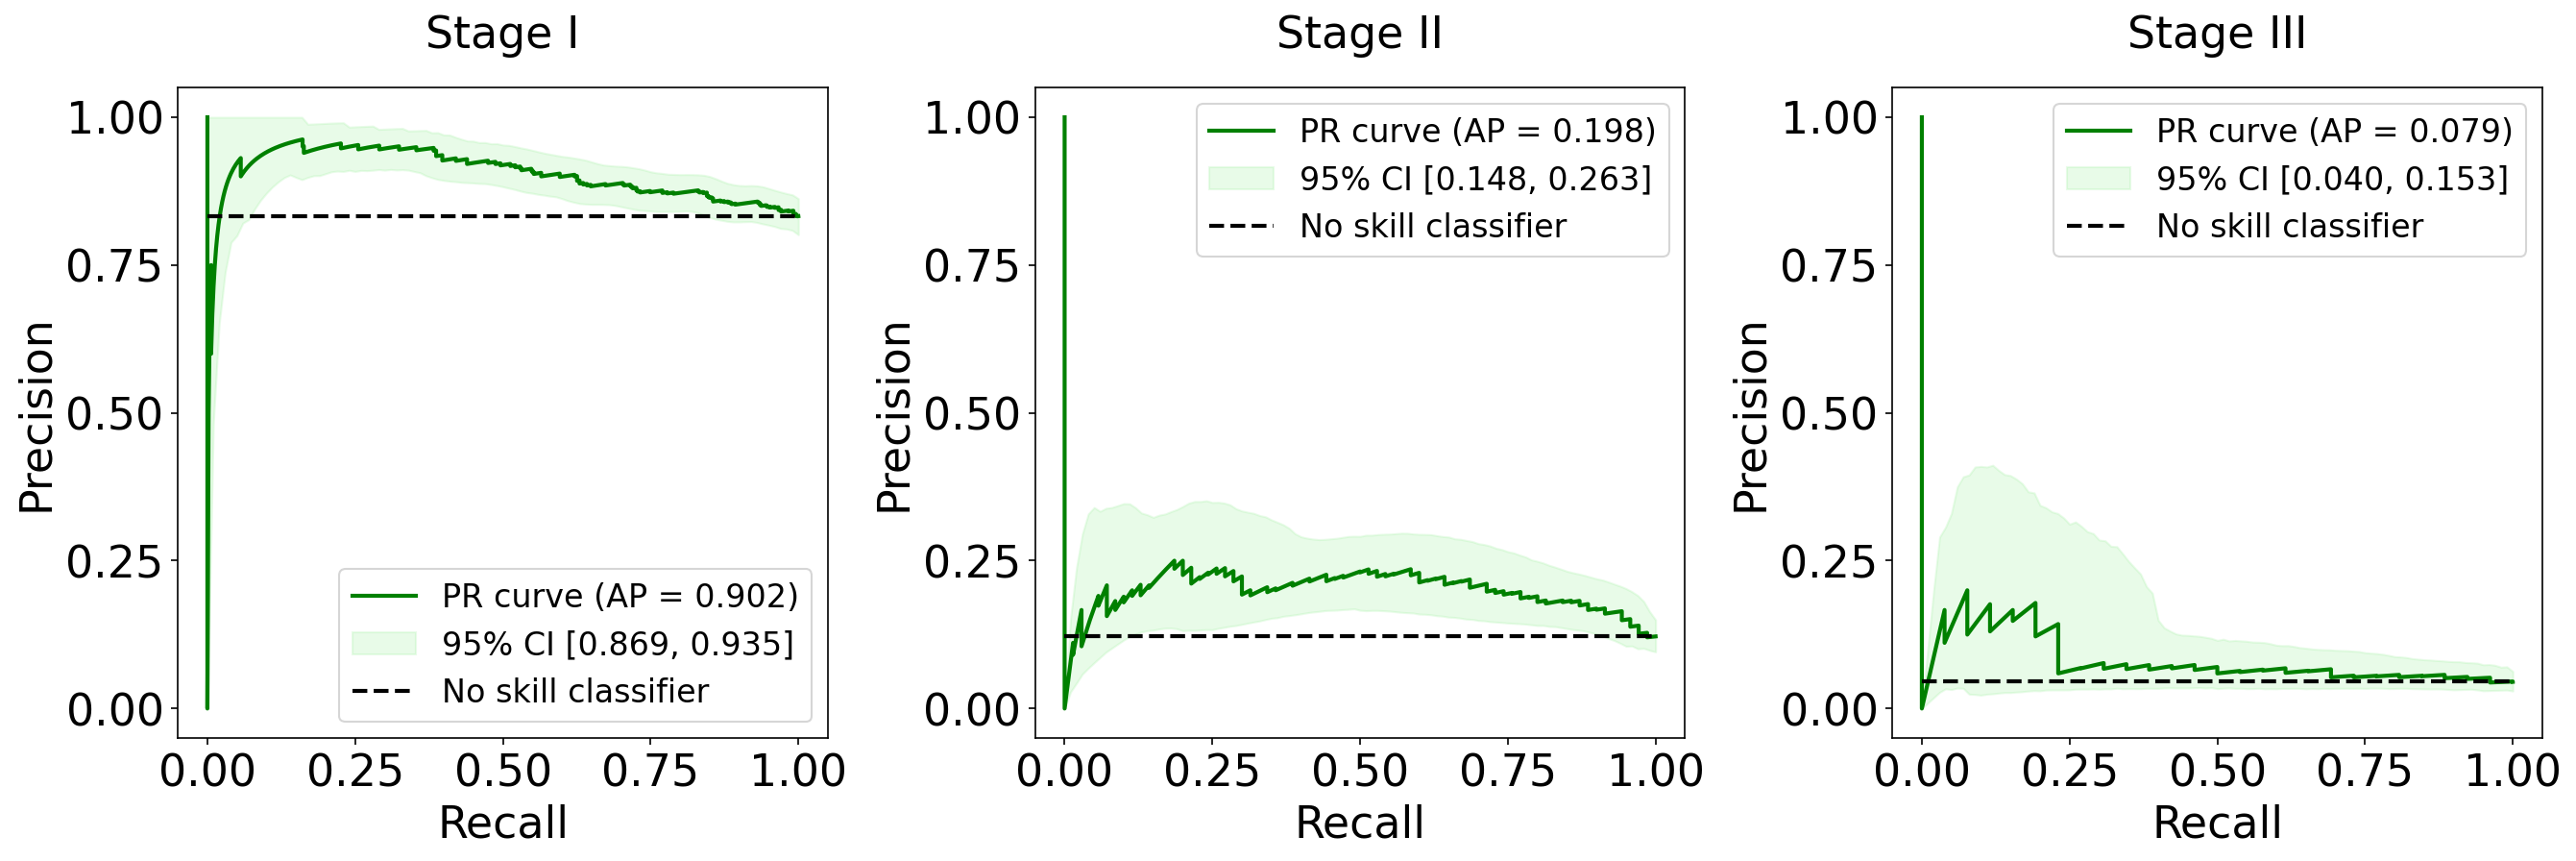

In [24]:
plot_pr_with_saved_bootstrap_simple_interp(bootstrap_samples, biopsy_df_local_test.Pathological.values-1, final_pred_ensemble_local_test)

### PR curve with CI - proper interp

### Confusion matrix - default argmax

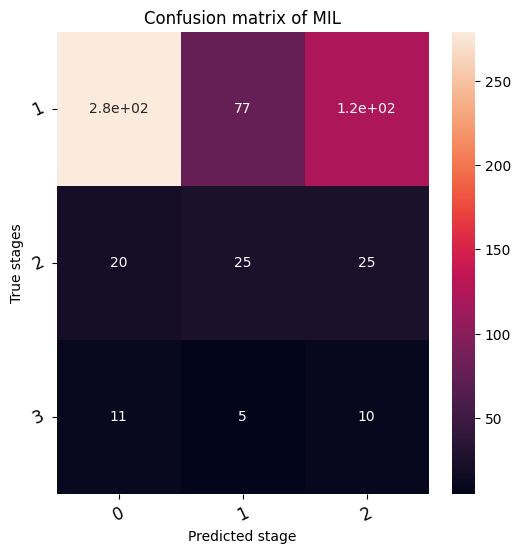

In [25]:
# calculating the confusion matrix
confusion_matrix_initial = pd.crosstab( biopsy_df_local_test.Pathological.values, np.argmax( final_pred_ensemble_local_test, axis=1),
                                rownames=['True stages'], colnames=['Predicted stage'] )
#print( confusion_matrix )

confusion_matrix_padded = confusion_matrix_initial.reindex(index=range(1, 4), columns=range(0, 3), fill_value=0)

custom_heatmap = np.round(confusion_matrix_padded,0).astype(int).astype(str) #+ ' ± ' + std_confusion_matrix_tuned.round(0).astype(int).astype(str)


# visualizng it on a heatmap
plt.figure(figsize=(6,6), dpi=100)
plt.title( 'Confusion matrix of MIL')
sns.heatmap(confusion_matrix_padded, annot=True, 
            #xticklabels=np.array(lb.classes_), 
            #yticklabels=np.array(lb.classes_), annot_kws={"size": 20}
           )
plt.tick_params(labelsize=12, rotation=25)
plt.xlabel('Predicted stage')
plt.show()

### Confusion matrix - tuned thresholds before after

In [26]:
final_pred_ensemble_local_test.shape

(574, 3)

In [27]:
# Create an empty list to store confusion matrices
confusion_matrices = []
predicted_labels_test = give_back_hard_label_predictions_with_threshold_tuning(final_pred_ensemble_local_test, thresholds_final)
    
# Calculate the confusion matrix for this set
confusion_matrix = pd.crosstab(biopsy_df_local_test.Pathological.values, predicted_labels_test, rownames=['True stages'], colnames=['Predicted stage'])

# Append the confusion matrix to the list
confusion_matrices.append(confusion_matrix)

# Calculate the mean and standard error of the confusion matrices

#confusion_matrix_padded = confusion_matrix_initial.reindex(index=range(1, 5), columns=range(0, 4), fill_value=0)

mean_confusion_matrix_tuned = sum(confusion_matrices) / len(confusion_matrices)
std_confusion_matrix_tuned = np.std(confusion_matrices, axis=0)

# Create a custom heatmap with mean values and overlay standard deviations
custom_heatmap_tuned = np.round(mean_confusion_matrix_tuned,0).astype(int).astype(str) #+ ' ± ' + std_confusion_matrix_tuned.round(0).astype(int).astype(str)
#custom_heatmap = f'{np.round(mean_confusion_matrix,0).astype(int)} $\pm$ {std_confusion_matrix.round(0).astype(int)}'


# Plot the custom heatmap
#plt.figure(figsize=(8, 6), dpi=100)
#sns.heatmap(mean_confusion_matrix_tuned, annot=custom_heatmap_tuned, fmt="", cmap=sns.cm.rocket )#annot_kws={"size": 12})
#plt.tick_params(labelsize=12, rotation=25)
#plt.xlabel('Predicted stage')
#plt.show()

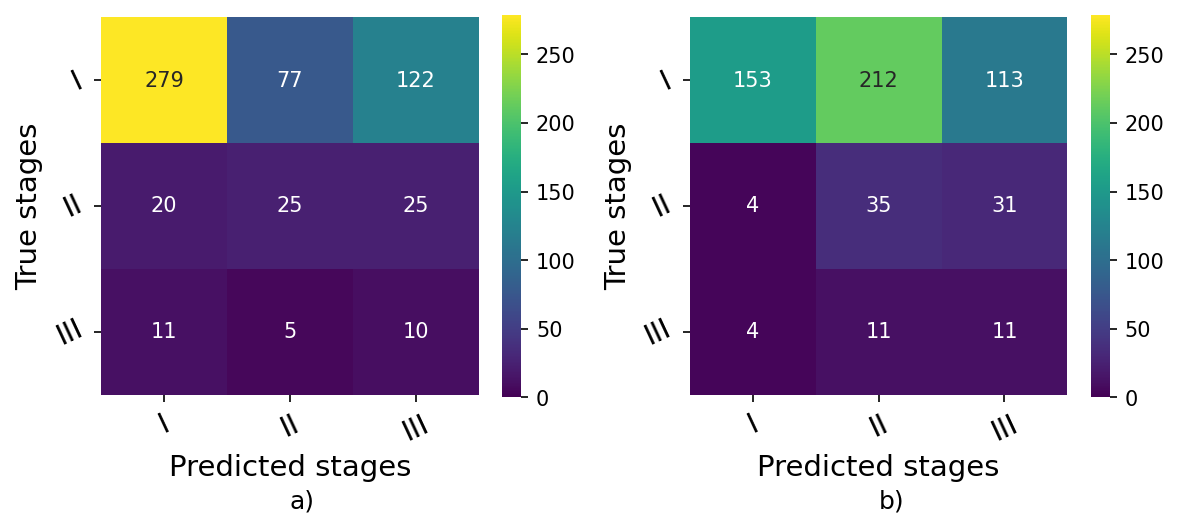

In [28]:
# Compute the maximum value in your confusion matrices
max_value = max(confusion_matrix_padded.values.max(), mean_confusion_matrix_tuned.values.max())

fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# First subplot
sns.heatmap(confusion_matrix_padded, annot=custom_heatmap, fmt="", cmap="viridis", ax=axes[0], vmin=0, vmax=max_value, cbar_kws={"shrink": 0.75} )
axes[0].set_ylabel('True stages', fontsize=14)
axes[0].set_xlabel('Predicted stages', fontsize=14)
axes[0].tick_params(labelsize=14)
axes[0].set_box_aspect(1)  # Ensures the heatmap is square (with all elements)
# Add more xticks for the first subplot
axes[0].text(0.5, -0.3, 'a)', transform=axes[0].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[0].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[0].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Second subplot
sns.heatmap(mean_confusion_matrix_tuned, annot=custom_heatmap_tuned, fmt="", cmap="viridis", ax=axes[1], vmin=0, vmax=max_value, cbar_kws={"shrink": 0.75}) 
axes[1].set_ylabel('True stages', fontsize=14)
axes[1].set_xlabel('Predicted stages', fontsize=14)
axes[1].tick_params(labelsize=14)
axes[1].set_box_aspect(1)  # Ensures the heatmap is square (with all elements)
# Add more xticks for the second subplot

axes[1].text(0.5, -0.3, 'b)', transform=axes[1].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[1].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[1].set_yticklabels(['I', 'II', 'III'], rotation=25)

plt.tight_layout()
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_before_after_rev.png')
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_before_after_rev.svg', format='svg')
plt.show()

### Confusion matrix - tuned thresholds before after normalized

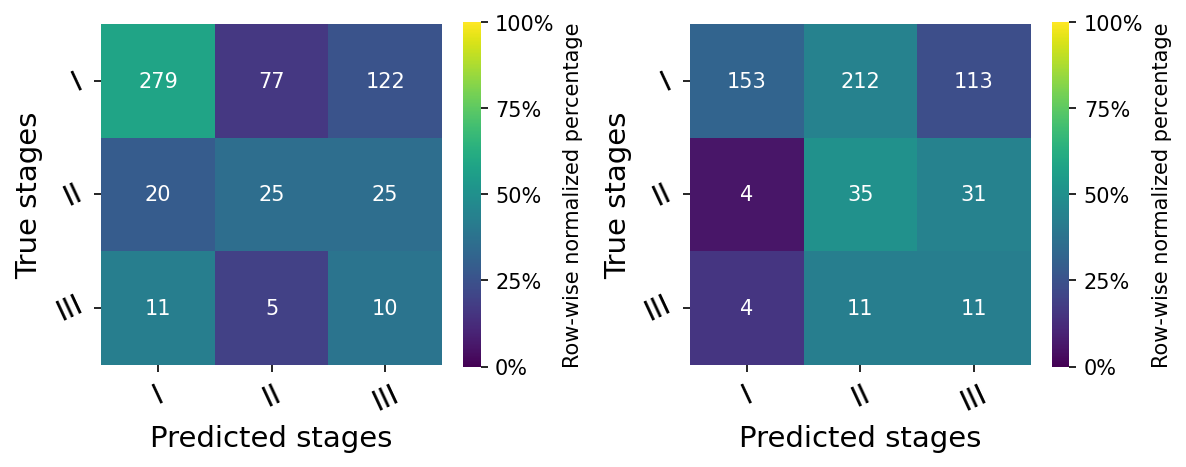

In [29]:
# Normalize confusion matrix (convert to numpy arrays first)
confusion_matrix_normalized = confusion_matrix_padded.values.astype('float') / confusion_matrix_padded.values.sum(axis=1)[:, np.newaxis]
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1)[:, np.newaxis]


# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# First subplot (normalized)
sns.heatmap(confusion_matrix_normalized, annot=custom_heatmap, fmt="", cmap='viridis', ax=axes[0], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[0].set_ylabel('True stages', fontsize=14)
axes[0].set_xlabel('Predicted stages', fontsize=14)
axes[0].tick_params(labelsize=14)
axes[0].set_box_aspect(1)
#axes[0].text(0.5, -0.3, 'a)', transform=axes[0].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[0].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[0].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Second subplot (normalized)
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_heatmap_tuned, fmt="", cmap='viridis', ax=axes[1], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[1].set_ylabel('True stages', fontsize=14)
axes[1].set_xlabel('Predicted stages', fontsize=14)
axes[1].tick_params(labelsize=14)
axes[1].set_box_aspect(1)
#axes[1].text(0.5, -0.3, 'b)', transform=axes[1].transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes[1].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[1].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Add colorbar labels and fix size for both subplots
for ax in axes:
    cbar = ax.collections[0].colorbar  # Access the colorbar
    cbar.set_label('Row-wise normalized percentage', fontsize=10)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.tick_params(labelsize=10)  # Adjust tick size
    #cbar.ax.set_aspect(17)  # Adjust aspect ratio of the colorbar to match the heatmap

plt.tight_layout()
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_before_after_normalized_with_percentage_rev.png')
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_before_after_normalized_with_percentage_rev.svg', format='svg')
plt.show()

### Confusion matrix - tuned thresholds

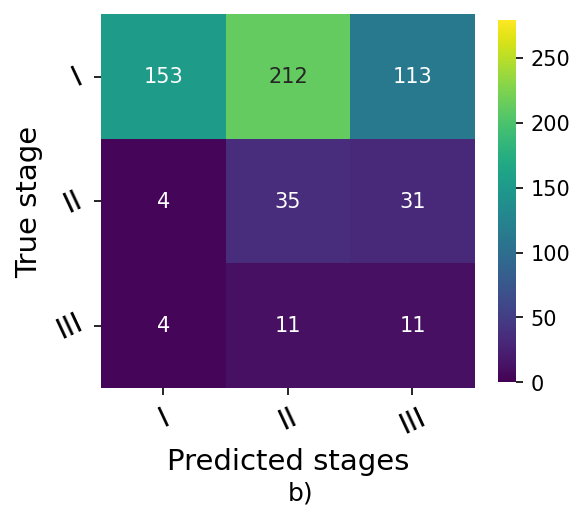

In [30]:
# Compute the maximum value in your confusion matrices
max_value = max(confusion_matrix_padded.values.max(), mean_confusion_matrix_tuned.values.max())

fig, axes = plt.subplots(1, 1, figsize=(4, 4), dpi=150)

# First subplot
sns.heatmap(mean_confusion_matrix_tuned, annot=custom_heatmap_tuned, fmt="", cmap="viridis", ax=axes, vmin=0, vmax=max_value, cbar_kws={"shrink": 0.75} )
axes.set_ylabel('True stage', fontsize=14)
axes.set_xlabel('Predicted stages', fontsize=14)
axes.tick_params(labelsize=14)
axes.set_box_aspect(1)  # Ensures the heatmap is square (with all elements)
# Add more xticks for the second subplot

axes.text(0.5, -0.3, 'b)', transform=axes.transAxes, fontsize=12)

# Set custom tick labels for x and y axes
axes.set_xticklabels(['I', 'II', 'III'], rotation=25)
axes.set_yticklabels(['I', 'II', 'III'], rotation=25)

plt.tight_layout()
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_rev.png')
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_rev.svg', format='svg')

#### Confusion matrix - tuned thresholds normalized

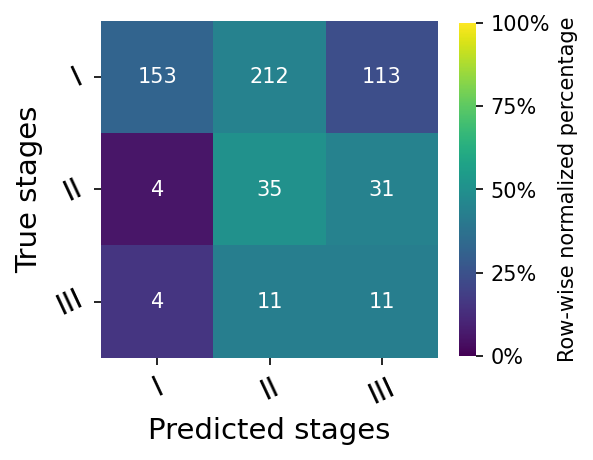

In [31]:
# Normalize confusion matrix (convert to numpy arrays first)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1)[:, np.newaxis]


# Plot
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Second subplot (normalized)
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_heatmap_tuned, fmt="", cmap='viridis', ax=ax, vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
ax.set_ylabel('True stages', fontsize=14)
ax.set_xlabel('Predicted stages', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_box_aspect(1)

# Set custom tick labels for x and y axes
ax.set_xticklabels(['I', 'II', 'III'], rotation=25)
ax.set_yticklabels(['I', 'II', 'III'], rotation=25)

# Add colorbar labels and fix size
cbar = ax.collections[0].colorbar  # Access the colorbar
cbar.set_label('Row-wise normalized percentage', fontsize=10)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
cbar.ax.tick_params(labelsize=10)  # Adjust tick size

plt.tight_layout()

# Save the figure
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_after_normalized_with_percentage_rev.png')
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_after_normalized_with_percentage_rev.svg', format='svg')

# Show the plot
plt.show()


In [32]:
mean_confusion_matrix_normalized

array([[0.32008368, 0.44351464, 0.23640167],
       [0.05714286, 0.5       , 0.44285714],
       [0.15384615, 0.42307692, 0.42307692]])

### Confusion matrix - tuned thresholds normalized - ratios

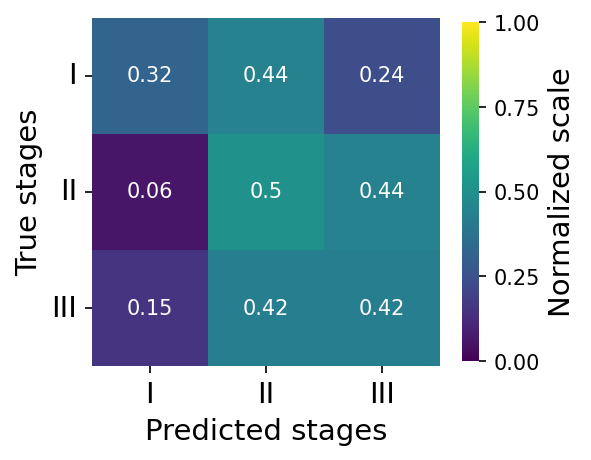

In [33]:
# Normalize confusion matrix (convert to numpy arrays first)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Second subplot (normalized)
sns.heatmap(mean_confusion_matrix_normalized, annot=np.round(mean_confusion_matrix_normalized, 2), fmt="", cmap='viridis', ax=ax, vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
ax.set_ylabel('True stages', fontsize=14)
ax.set_xlabel('Predicted stages', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_box_aspect(1)

# Set custom tick labels for x and y axes
ax.set_xticklabels(['I', 'II', 'III'], rotation=0)
ax.set_yticklabels(['I', 'II', 'III'], rotation=0)

# Add colorbar labels and fix size
cbar = ax.collections[0].colorbar  # Access the colorbar
cbar.set_label('Normalized scale', fontsize=14)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=10)  # Adjust tick size

plt.tight_layout()

# Save the figure
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_row_normalized_rev.png')
#plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_uni_finetuned_row_normalized_rev.svg', format='svg')

# Show the plot
plt.show()


### Confusion matrix - tuned thresholds normalized - ratios and main values

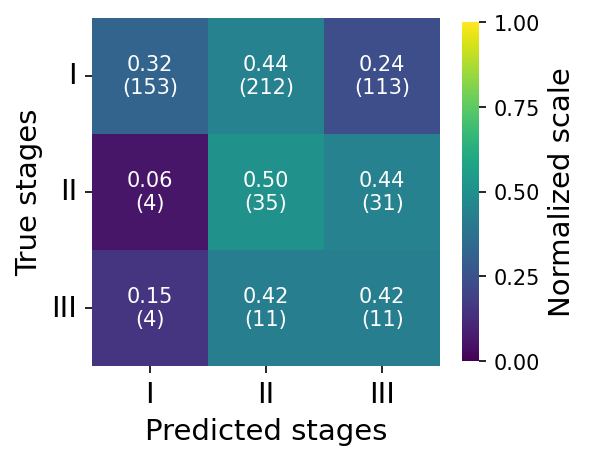

In [34]:
# Normalize confusion matrix (convert to numpy arrays first)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1, keepdims=True)


# Create custom annotations with percentages as main and actual values in parentheses
custom_annotations = np.empty_like(mean_confusion_matrix_tuned.values, dtype=object)
for i in range(mean_confusion_matrix_tuned.shape[0]):
    for j in range(mean_confusion_matrix_tuned.shape[1]):
        actual_value = int(mean_confusion_matrix_tuned.values[i, j])
        percentage_value = mean_confusion_matrix_normalized[i, j] 
        custom_annotations[i, j] = f"{percentage_value:.2f}\n({actual_value})"

# Plot
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Heatmap with both percentages and actual values
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_annotations, fmt="", cmap='viridis', ax=ax, vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
ax.set_ylabel('True stages', fontsize=14)
ax.set_xlabel('Predicted stages', fontsize=14)
ax.tick_params(labelsize=14)
ax.set_box_aspect(1)

# Set custom tick labels for x and y axes
ax.set_xticklabels(['I', 'II', 'III'], rotation=0)
ax.set_yticklabels(['I', 'II', 'III'], rotation=0)

# Add colorbar labels and fix size
cbar = ax.collections[0].colorbar  # Access the colorbar
cbar.set_label('Normalized scale', fontsize=14)
cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
cbar.ax.tick_params(labelsize=10)  # Adjust tick size

plt.tight_layout()

# Save the figure
plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_combined_percentages_main_uni_finetuned_rev.png')
plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_combined_percentages_main_uni_finetuned_rev.svg', format='svg')

# Show the plot
plt.show()

### Confusion matrix - tuned thresholds normalized - ratios and main values - before after

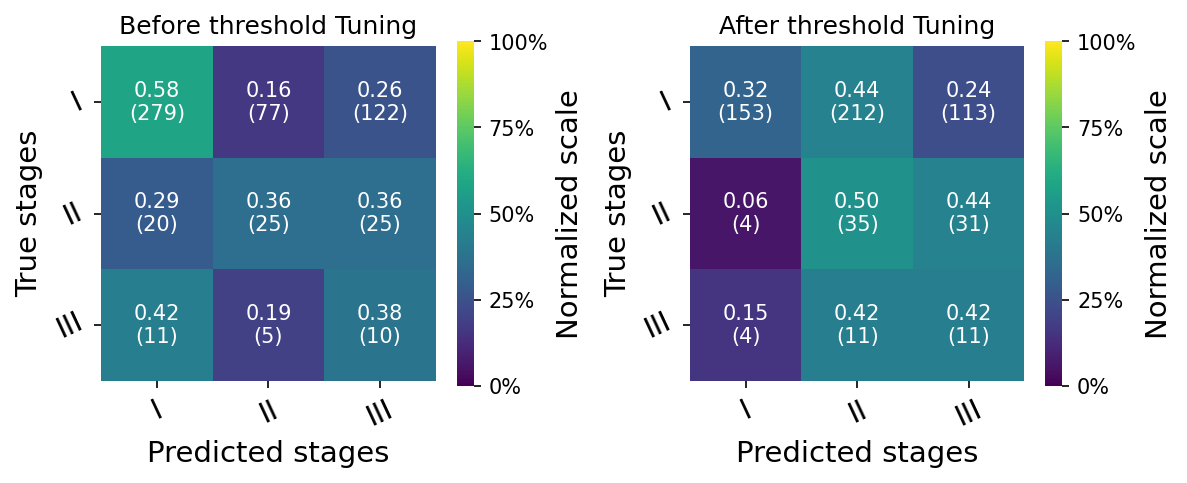

In [35]:
# Normalize confusion matrices (convert to numpy arrays first)
confusion_matrix_normalized = confusion_matrix_padded.values.astype('float') / confusion_matrix_padded.values.sum(axis=1, keepdims=True)
mean_confusion_matrix_normalized = mean_confusion_matrix_tuned.values.astype('float') / mean_confusion_matrix_tuned.values.sum(axis=1, keepdims=True)

# Create custom annotations combining actual values and percentages for "before tuning"
custom_annotations_before = np.empty_like(confusion_matrix_padded.values, dtype=object)
for i in range(confusion_matrix_padded.shape[0]):
    for j in range(confusion_matrix_padded.shape[1]):
        actual_value = int(confusion_matrix_padded.values[i, j])
        percentage_value = confusion_matrix_normalized[i, j]
        custom_annotations_before[i, j] = f"{percentage_value:.2f}\n({actual_value})"

# Create custom annotations combining actual values and percentages for "after tuning"
custom_annotations_after = np.empty_like(mean_confusion_matrix_tuned.values, dtype=object)
for i in range(mean_confusion_matrix_tuned.shape[0]):
    for j in range(mean_confusion_matrix_tuned.shape[1]):
        actual_value = int(mean_confusion_matrix_tuned.values[i, j])
        percentage_value = mean_confusion_matrix_normalized[i, j]
        custom_annotations_after[i, j] = f"{percentage_value:.2f}\n({actual_value})"

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

# First subplot (before tuning)
sns.heatmap(confusion_matrix_normalized, annot=custom_annotations_before, fmt="", cmap='viridis', ax=axes[0], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[0].set_ylabel('True stages', fontsize=14)
axes[0].set_xlabel('Predicted stages', fontsize=14)
axes[0].tick_params(labelsize=14)
axes[0].set_box_aspect(1)
axes[0].set_title('Before threshold Tuning')

# Set custom tick labels for x and y axes
axes[0].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[0].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Second subplot (after tuning)
sns.heatmap(mean_confusion_matrix_normalized, annot=custom_annotations_after, fmt="", cmap='viridis', ax=axes[1], vmin=0, vmax=1, cbar_kws={"shrink": 0.65})
axes[1].set_ylabel('True stages', fontsize=14)
axes[1].set_xlabel('Predicted stages', fontsize=14)
axes[1].tick_params(labelsize=14)
axes[1].set_box_aspect(1)
axes[1].set_title('After threshold Tuning')

# Set custom tick labels for x and y axes
axes[1].set_xticklabels(['I', 'II', 'III'], rotation=25)
axes[1].set_yticklabels(['I', 'II', 'III'], rotation=25)

# Add colorbar labels and fix size for both subplots
for ax in axes:
    cbar = ax.collections[0].colorbar  # Access the colorbar
    cbar.set_label('Normalized scale', fontsize=14)
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.tick_params(labelsize=10)  # Adjust tick size

# Final plot adjustments and saving
plt.tight_layout()
plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_combined_percentages_main_before_after_uni_finetuned_rev.png')
plt.savefig('paper_figures_rev_excluded_slides_cluster_tsne_1_2_3/confmat_NG_cohort_combined_percentages_main_before_after_uni_finetuned_rev.svg', format='svg')
plt.show()